In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

In [6]:



classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
selected_classes = ['airplane', 'automobile', 'bird']
class_indices = [classes.index(cls) for cls in selected_classes]

# Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def filter_classes(dataset, indices):
    filtered_data = [(img, label) for img, label in dataset if label in indices]
    return filtered_data

filtered_data = filter_classes(dataset, class_indices)
filtered_test_data = filter_classes(test_dataset, class_indices)

class CustomCIFAR10(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

train_data = CustomCIFAR10(filtered_data)
test_data = CustomCIFAR10(filtered_test_data)

train_len = int(0.8 * len(train_data))
val_len = len(train_data) - train_len
train_data, val_data = random_split(train_data, [train_len, val_len])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


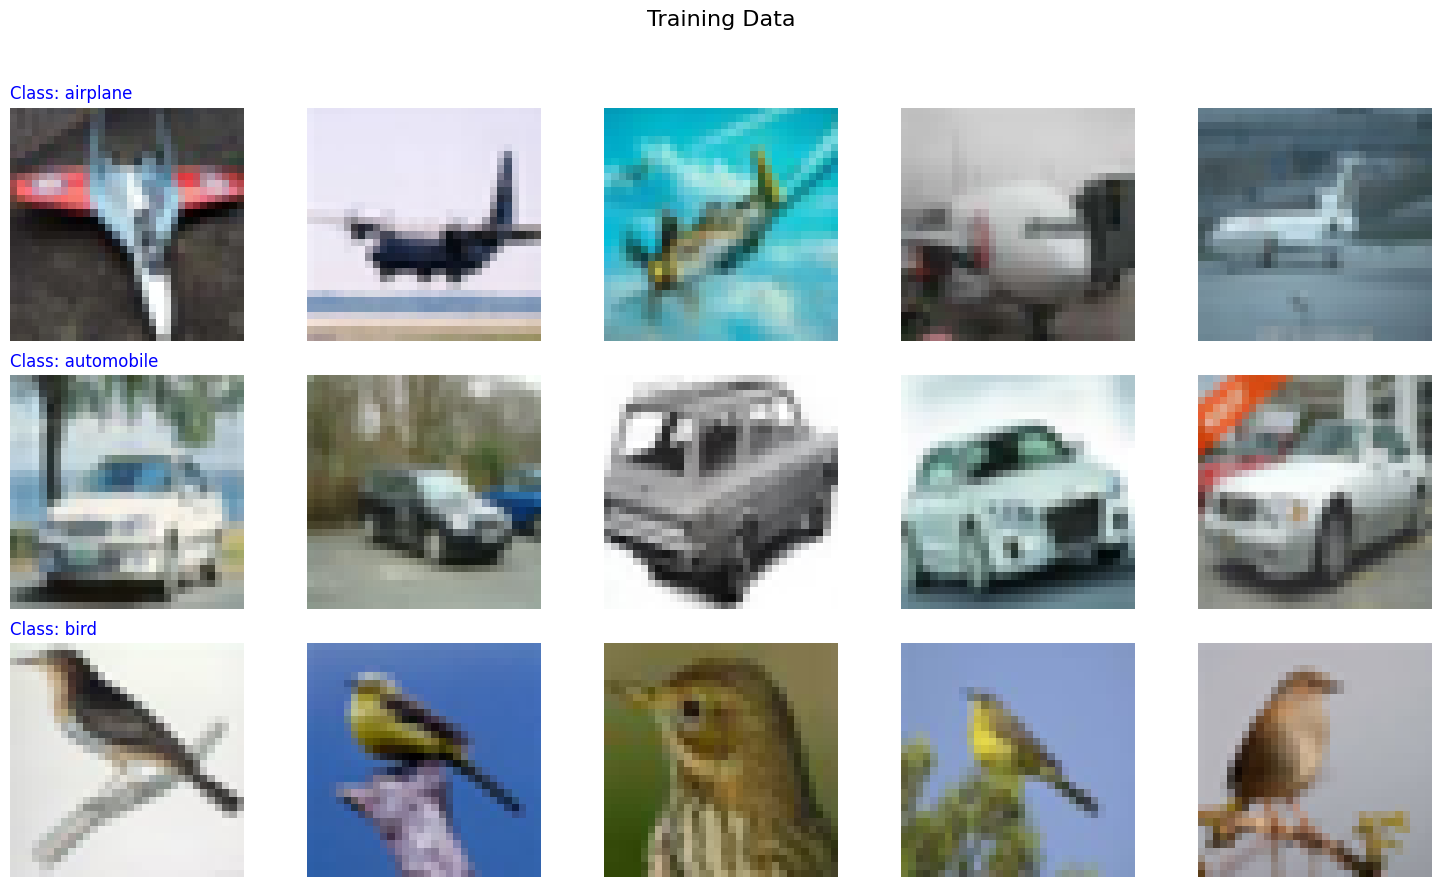

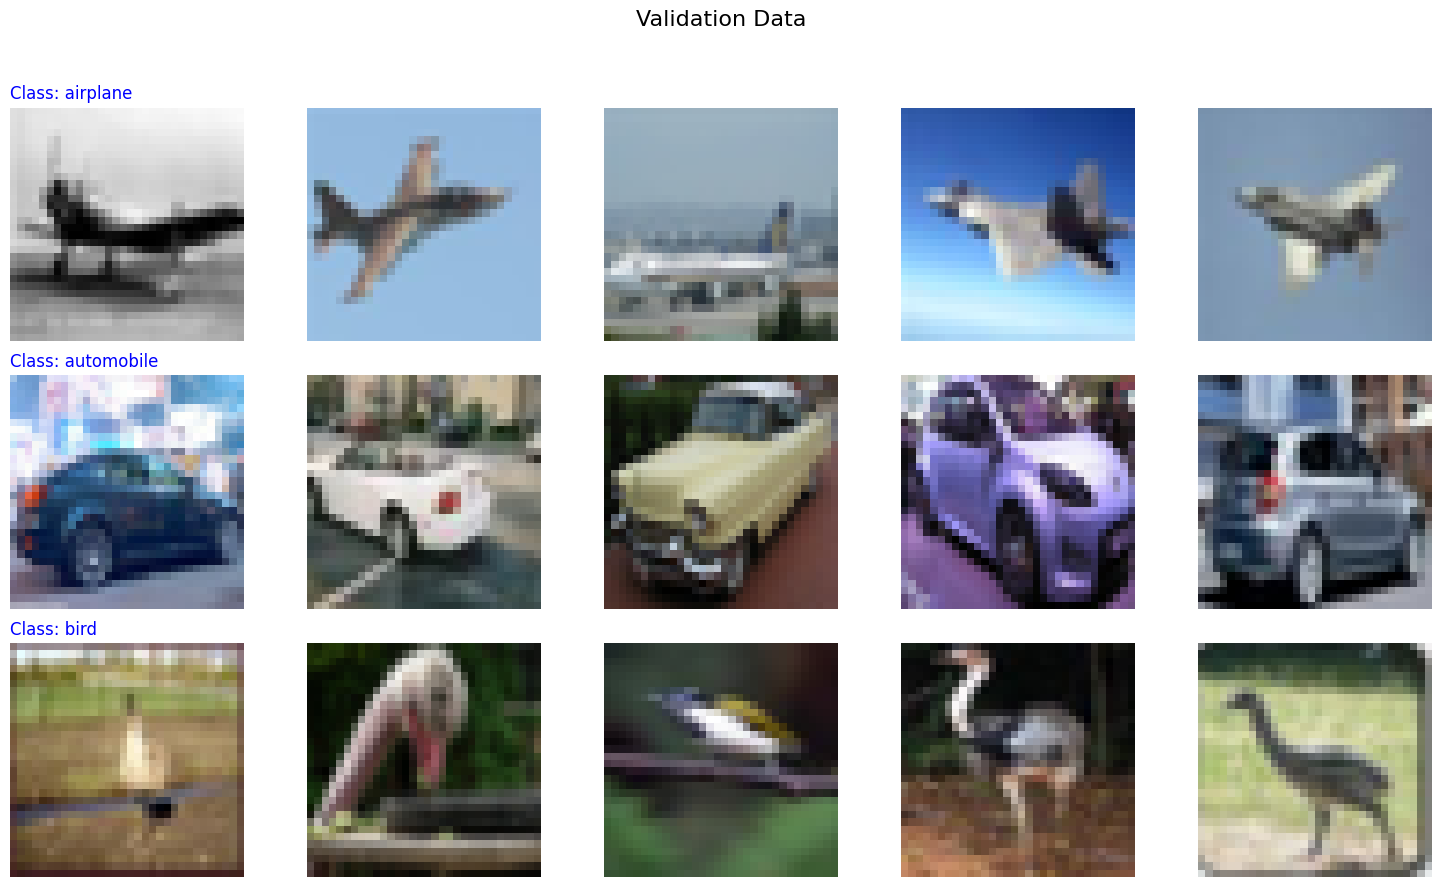

In [7]:
def visualize_data(loader, classes, title, images_per_class=5):
    class_images = {cls: [] for cls in range(len(classes))}

    for images, labels in loader:
        for img, label in zip(images, labels):
            if len(class_images[label.item()]) < images_per_class:
                class_images[label.item()].append(img)
        if all(len(images) >= images_per_class for images in class_images.values()):
            break

    fig, axes = plt.subplots(len(classes), images_per_class, figsize=(15, len(classes) * 3))
    for cls_idx, cls_name in enumerate(classes):
        for img_idx in range(images_per_class):
            ax = axes[cls_idx, img_idx] if len(classes) > 1 else axes[img_idx]
            img = class_images[cls_idx][img_idx]
            ax.imshow(np.transpose((img / 2 + 0.5).numpy(), (1, 2, 0)))  # Normalize and convert to HWC format
            ax.axis('off')
        axes[cls_idx, 0].set_title(f"Class: {cls_name}", fontsize=12, loc='left', color='blue')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

visualize_data(train_loader, selected_classes, "Training Data")
visualize_data(val_loader, selected_classes, "Validation Data")


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        
        self._calculate_flattened_size()
        
        self.fc1 = nn.Linear(self.flattened_size, 16) 
        self.fc2 = nn.Linear(16, num_classes)

        # used for debug
    def _calculate_flattened_size(self):
        dummy_input = torch.zeros(1, 3, 32, 32)  
        x = self.pool(torch.relu(self.conv1(dummy_input)))
        x = self.pool2(torch.relu(self.conv2(x)))
        self.flattened_size = x.numel()  

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  
        x = self.pool2(torch.relu(self.conv2(x)))  
        x = x.view(x.size(0), -1) 
        x = torch.relu(self.fc1(x)) 
        x = self.fc2(x)  
        return x


Epoch 1/15, Train Loss: 0.8380, Val Loss: 0.5908, Train Acc: 65.03, Val Acc: 76.63
Epoch 2/15, Train Loss: 0.5568, Val Loss: 0.5074, Train Acc: 77.75, Val Acc: 80.30
Epoch 3/15, Train Loss: 0.5018, Val Loss: 0.4652, Train Acc: 80.00, Val Acc: 80.80
Epoch 4/15, Train Loss: 0.4498, Val Loss: 0.4336, Train Acc: 82.24, Val Acc: 82.63
Epoch 5/15, Train Loss: 0.4027, Val Loss: 0.3879, Train Acc: 84.01, Val Acc: 84.57
Epoch 6/15, Train Loss: 0.3856, Val Loss: 0.3593, Train Acc: 84.69, Val Acc: 86.03
Epoch 7/15, Train Loss: 0.3595, Val Loss: 0.3803, Train Acc: 86.22, Val Acc: 85.23
Epoch 8/15, Train Loss: 0.3451, Val Loss: 0.3471, Train Acc: 86.66, Val Acc: 86.13
Epoch 9/15, Train Loss: 0.3351, Val Loss: 0.3394, Train Acc: 87.08, Val Acc: 86.87
Epoch 10/15, Train Loss: 0.3170, Val Loss: 0.3293, Train Acc: 87.84, Val Acc: 86.93
Epoch 11/15, Train Loss: 0.3062, Val Loss: 0.3596, Train Acc: 88.33, Val Acc: 86.43
Epoch 12/15, Train Loss: 0.2942, Val Loss: 0.3232, Train Acc: 88.62, Val Acc: 87.80
E

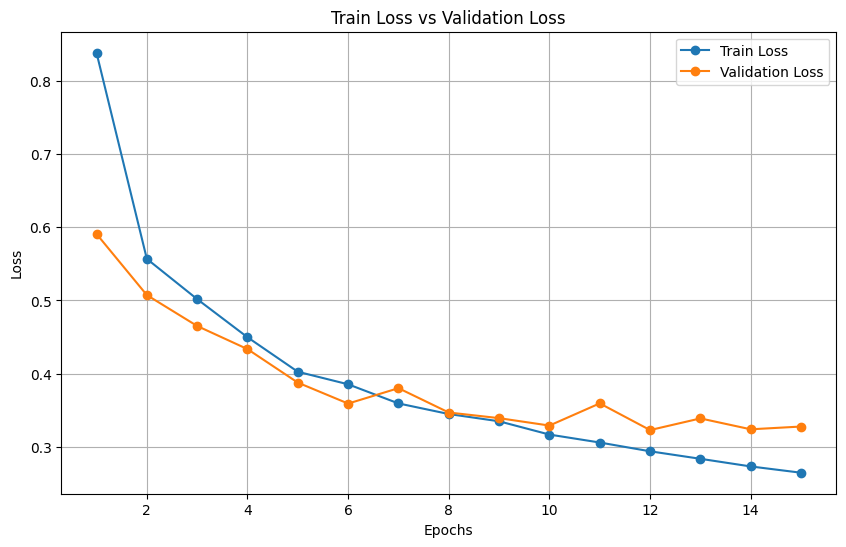

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, save_path, device):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # print(f"Epoch {epoch+1}, Batch {batch_idx+1}")
            # print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")

            optimizer.zero_grad()
            outputs = model(inputs)

            # print(f"Outputs shape: {outputs.shape}")

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            max_vals, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                # print(f"Validation - Batch {batch_idx+1}")
                # print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")

                outputs = model(inputs)

                # print(f"Validation Outputs shape: {outputs.shape}")

                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                max_vals, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_loss.append(val_running_loss / len(val_loader))
        val_acc.append(100 * val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}, Val Acc: {val_acc[-1]:.2f}")

    torch.save(model.state_dict(), save_path)
    return train_loss, val_loss, train_acc, val_acc


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # Adjust for AMD GPU
cnn_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

cnn_train_loss, cnn_val_loss, cnn_train_acc, cnn_val_acc = train_model(
    cnn_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=15,
    save_path="cnn_model.pth",
    device=device
)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cnn_train_loss) + 1), cnn_train_loss, label='Train Loss', marker='o')
plt.plot(range(1, len(cnn_val_loss) + 1), cnn_val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# CNN 
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader, device, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            max_values, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss /len(dataloader)
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = (cm.diagonal().sum()/cm.sum()) * 100
    f1 = classification_report(all_labels, all_preds, output_dict=True)['weighted avg']['f1-score']
    
    return avg_loss, accuracy, f1, cm



C:\Users\Rishi\AppData\Local\Temp\ipykernel_17040\2420577050.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load('cnn_model.pth'))


Test Loss: 0.3303, Test Accuracy: 87.43%, Test F1 Score: 0.8731


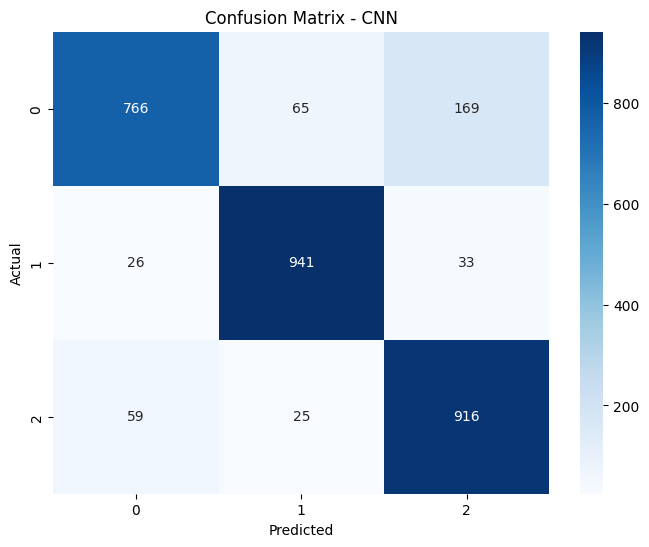

In [11]:
cnn_model.load_state_dict(torch.load('cnn_model.pth'))
cnn_model.eval()


test_loss, test_accuracy, test_f1, test_cm = evaluate_model(cnn_model, test_loader, device, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1 Score: {test_f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Epoch 1/15, Train Loss: 0.6962, Val Loss: 0.6080, Val Acc: 75.70%, Val F1: 0.7569
Epoch 2/15, Train Loss: 0.5702, Val Loss: 0.5575, Val Acc: 78.30%, Val F1: 0.7831
Epoch 3/15, Train Loss: 0.5197, Val Loss: 0.5684, Val Acc: 77.33%, Val F1: 0.7728
Epoch 4/15, Train Loss: 0.4692, Val Loss: 0.5362, Val Acc: 78.87%, Val F1: 0.7892
Epoch 5/15, Train Loss: 0.4352, Val Loss: 0.5474, Val Acc: 79.20%, Val F1: 0.7919
Epoch 6/15, Train Loss: 0.4099, Val Loss: 0.5371, Val Acc: 79.73%, Val F1: 0.7970
Epoch 7/15, Train Loss: 0.3720, Val Loss: 0.5484, Val Acc: 79.37%, Val F1: 0.7945
Epoch 8/15, Train Loss: 0.3526, Val Loss: 0.5424, Val Acc: 79.90%, Val F1: 0.7986
Epoch 9/15, Train Loss: 0.3280, Val Loss: 0.5713, Val Acc: 78.17%, Val F1: 0.7817
Epoch 10/15, Train Loss: 0.3043, Val Loss: 0.5570, Val Acc: 80.93%, Val F1: 0.8086
Epoch 11/15, Train Loss: 0.2871, Val Loss: 0.5794, Val Acc: 79.30%, Val F1: 0.7936
Epoch 12/15, Train Loss: 0.2619, Val Loss: 0.5828, Val Acc: 79.63%, Val F1: 0.7957
Epoch 13/15, 

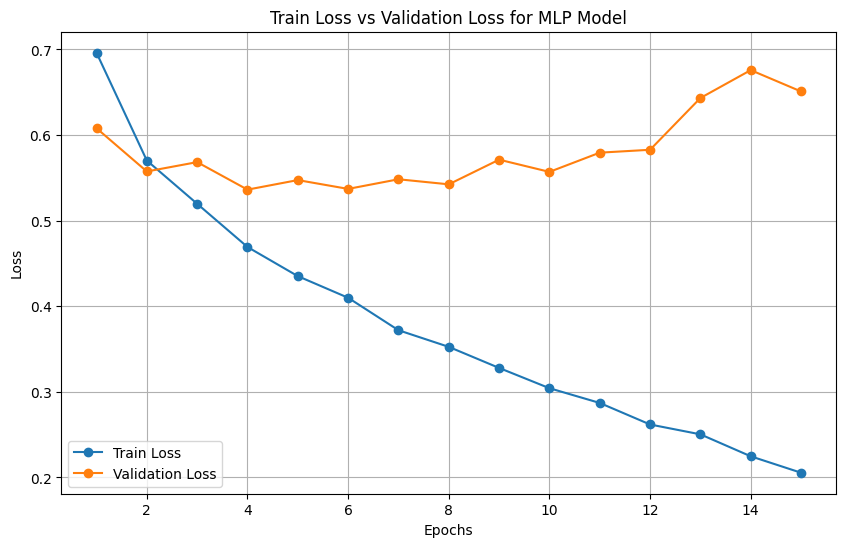

In [12]:
# MLP
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

mlp_model = MLPModel(input_size=32*32*3, hidden_size=64, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

num_epochs = 15

# train
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    mlp_model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mlp_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # val
    val_loss, val_accuracy, val_f1, _ = evaluate_model(mlp_model, val_loader, device, criterion)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Val F1: {val_f1:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss for MLP Model')
plt.legend()
plt.grid(True)
plt.show()


torch.save(mlp_model.state_dict(), "mlp_model.pth")

MLP Test Loss: 0.6474, Test Accuracy: 79.63%, Test F1 Score: 0.7971


C:\Users\Rishi\AppData\Local\Temp\ipykernel_17040\382741248.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load("mlp_model.pth"))


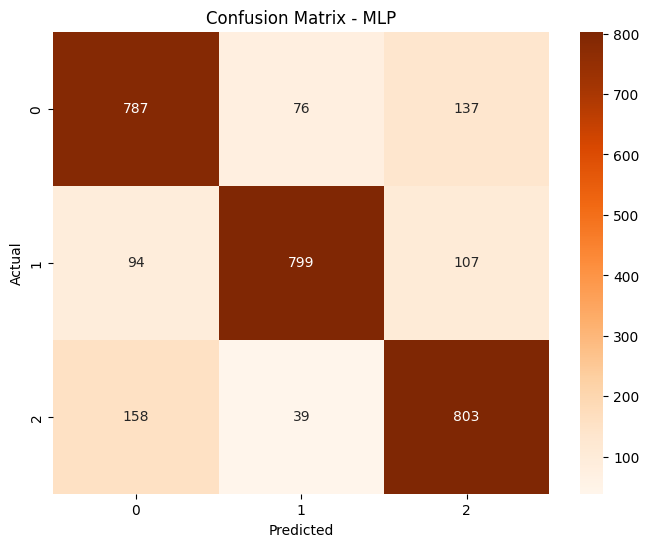

In [13]:
mlp_model.load_state_dict(torch.load("mlp_model.pth"))
mlp_model.eval()  

test_loss_mlp, test_accuracy_mlp, test_f1_mlp, test_cm_mlp = evaluate_model(mlp_model, test_loader, device, criterion)

print(f"MLP Test Loss: {test_loss_mlp:.4f}, Test Accuracy: {test_accuracy_mlp:.2f}%, Test F1 Score: {test_f1_mlp:.4f}")

# Plot 
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm_mlp, annot=True, fmt='d', cmap="Oranges")
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [14]:
print("Comparison of CNN and MLP Models:")
print(f"CNN Test Accuracy: {test_accuracy:.2f}%, Test F1 Score: {test_f1:.4f}")
print(f"MLP Test Accuracy: {test_accuracy_mlp:.2f}%, Test F1 Score: {test_f1_mlp:.4f}")

Comparison of CNN and MLP Models:
CNN Test Accuracy: 87.43%, Test F1 Score: 0.8731
MLP Test Accuracy: 79.63%, Test F1 Score: 0.7971
